<a href="https://colab.research.google.com/github/kmayutrisna/IMDB/blob/main/IMDB_Bert%2BCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.6 MB/s eta 0:00:00


In [2]:
# Import necessary library
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re
from google.colab import drive
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer

In [3]:
#Get the dataset from gdrive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Display top of data
data =pd.read_csv("drive/My Drive/data/IMDB Dataset.csv")

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
# Text preprocessing
def preprocess_text(text):

    # Text cleaning
    text = re.sub('[^a-zA-Z]', ' ', text)

    #Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    #Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Lowercasing
    text = text.lower()

    # Lowercasing
    text = text.split()

    # Stopword removal
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if not word in stop_words]

    # Join the tokens back to a single string
    text = ' '.join(text)
    return text

In [7]:
# Preprocess the text column
data['review'] = data['review'].apply(preprocess_text)

In [8]:
# Preprocess the text data
texts = data['review'].values
labels = data['sentiment'].map({'positive': 1, 'negative': 0}).values

In [9]:
# Split the dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [10]:
# Define the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [11]:
# Tokenize the texts and pad the sequences
train_encodings = tokenizer.batch_encode_plus(
    train_data.tolist(),
    truncation=True,
    padding=True,
    return_token_type_ids=False,
    max_length=512
)


test_encodings = tokenizer.batch_encode_plus(
    test_data.tolist(),
    truncation=True,
    padding=True,
    return_token_type_ids=False,
    max_length=512
)

In [12]:
# Convert the tokenized inputs to numpy arrays
train_inputs = np.array(train_encodings['input_ids'])
train_labels = np.array(train_labels)
test_inputs = np.array(test_encodings['input_ids'])
test_labels = np.array(test_labels)

In [13]:
# Pad the sequences
train_inputs = pad_sequences(train_inputs, maxlen=512, padding='post')
test_inputs = pad_sequences(test_inputs, maxlen=512, padding='post')

In [14]:
# Build CNN Model
model = Sequential()
model.add(Embedding(30522, 100, input_length=512))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

#model = keras.Sequential([
#    Embedding(num_words, embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False),
 #   Conv1D(128, 5, activation='relu'),
  #  MaxPooling1D(5),
   # Flatten(),
    #Dense(1, activation='sigmoid')
#])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
# Train the Model
epochs = 5
batch_size = 128

history = model.fit(train_inputs, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/5
250/250 [==============================] - 212s 842ms/step - loss: 0.4122 - accuracy: 0.7894 - val_loss: 0.2774 - val_accuracy: 0.8870
Epoch 2/5
250/250 [==============================] - 195s 779ms/step - loss: 0.1758 - accuracy: 0.9354 - val_loss: 0.2932 - val_accuracy: 0.8831
Epoch 3/5
250/250 [==============================] - 205s 820ms/step - loss: 0.0813 - accuracy: 0.9731 - val_loss: 0.4067 - val_accuracy: 0.8740
Epoch 4/5
250/250 [==============================] - 205s 818ms/step - loss: 0.0280 - accuracy: 0.9925 - val_loss: 0.5313 - val_accuracy: 0.8740
Epoch 5/5
250/250 [==============================] - 206s 824ms/step - loss: 0.0086 - accuracy: 0.9984 - val_loss: 0.6630 - val_accuracy: 0.8714


In [16]:
# Assuming you already have predictions and test_labels

predictions = model.predict(test_inputs)
predictions = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

# Calculate Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(test_labels, predictions)
print(f"MCC Score: {mcc * 100:.2f}%")

313/313 [==============================] - 17s 53ms/step
Accuracy: 87.35%
Precision: 85.82%
Recall: 89.72%
F1 Score: 87.73%
MCC Score: 74.77%


In [17]:
# Calculate and print classification report
report = classification_report(test_labels, predictions, target_names=['Negative', 'Positive'])
print("Classification Report:\n", report)

# Calculate and print confusion matrix
confusion = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:\n", confusion)

Classification Report:
               precision    recall  f1-score   support

    Negative       0.89      0.85      0.87      4961
    Positive       0.86      0.90      0.88      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Confusion Matrix:
 [[4214  747]
 [ 518 4521]]


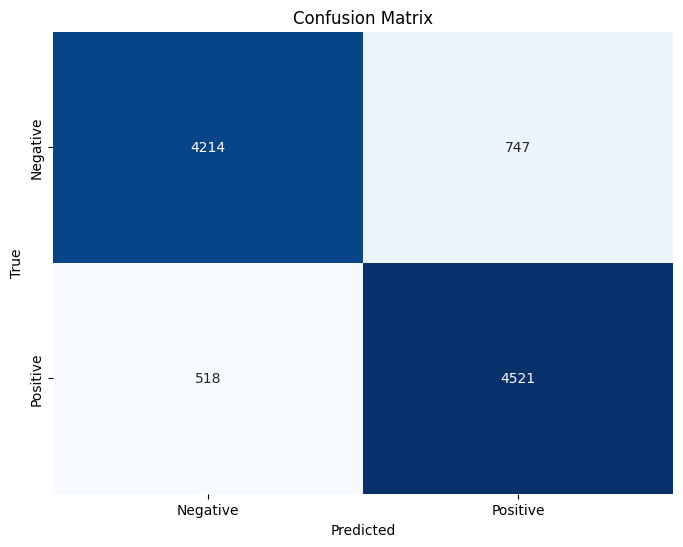

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
confusion = confusion_matrix(test_labels, predictions)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

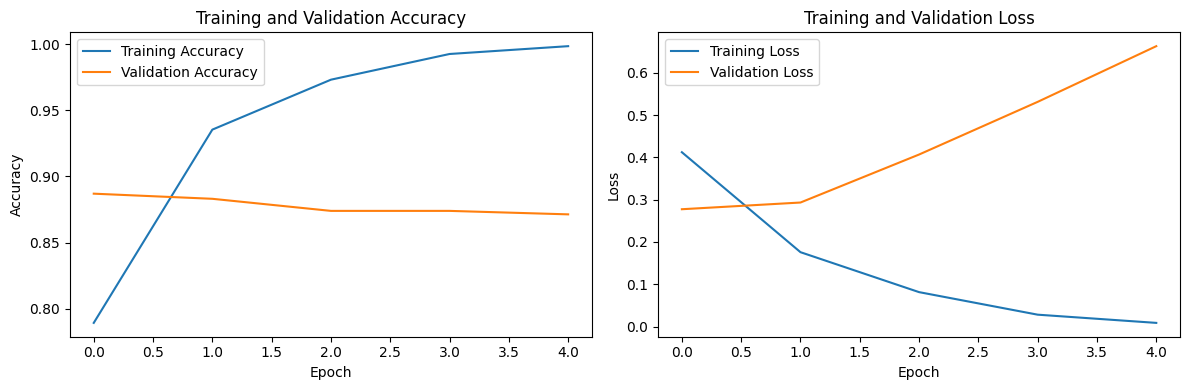

In [19]:
# Plot Training History (Accuracy and Loss)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()
